# **Montecarlo**
----

## Goals of this notebook:

1. Make sure that the most basic environment (HitStand) properly works.
2. Deploy main plotting utilities.
3. Execute a simple experiment to make sure that my hand-made Montecarlo-based algorithms (for both prediction and control) are mistake proof.
4. Define methods to accelerate multiple episode executions in later notebooks.
5. Showcase agents' common efficiency-oriented capabilities (e.g.: Q/V-table storage and agent storage).

---
## Library imports

#### 1. RL libraries:

In [2]:
import environments
from agents.agents import MonteCarloPredictor, MontecarloController, OffPolicyMontecarlo

#### 2. Data aggregation and matrix operation libraries:

In [3]:
import numpy as np
import pandas as pd

#### 3. Plotting libraries:

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Commands to tweak notebook layout:
from sys import maxsize
np.set_printoptions(threshold=maxsize)
plt.style.use('seaborn-pastel')

#### 4. Statistical analysis tools:

In [5]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import normaltest, anderson, t, kstest

----

## Common plotting utilities:

#### Average reward time series:

In [23]:
def plot_reward_time_series(X,Y):    
    max_domain = X[-1]
    domain = np.arange(X[0], max_domain + X[0] * 100, X[0] * 100)
    
    fig = plt.figure(figsize=(20,10))
    
    style_dict = {'xlim': (0, max_domain),
                  'xticks': domain,
                  'xticklabels': domain,
                  'xlabel': 'Episodes',
                  'ylim': (-1, 1),
                  'yticks': np.arange(-1, 1.1, 0.05),
                  'yticklabels': np.arange(-1, 1.1, 0.05),
                  'title': 'Average reward over last {0} episodes'.format(str(X[0]))
                 }
    
    ax = fig.add_subplot(1,1,1, **style_dict)
    ax.grid()
    #Axis formatters:
    formatter = ScalarFormatter()
    formatter.set_scientific(True)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.2f'))
    # in and out of the money border:
    ax.plot(domain.ravel(), np.zeros_like(domain).ravel(), color='red')
    ax.plot(X,Y)
    return ax

---

## Statistical functions:

I use an **alpha value of 5%** for any statistical test executed in this project

In [49]:
CONFIDENCE_STRING_FORMAT = '5%'
CONFIDENCE = 0.05

In [50]:
def dickey_fuller(time_series, confidence=CONFIDENCE_STRING_FORMAT):
    fuller_results = adfuller(results)
    if fuller_results[0] < fuller_results[4][confidence]:
        return 'Null hypothesis can be rejected. The series is stationary.'
    else:
        return 'Null hypothesis cannot be rejected. The series is not stationary'

----

## Basic enviroment presentation:

In [9]:
# AI gym-like enviroment instance creation:
env = environments.make('hitstand')

In [10]:
print(env)
# Main rules:

1. 6 decks (with replacement after each episode)
2. Dealer stands on soft 17
3. No Double Down
4. No split
5. No insurance offered
6. No surrender
7. Natural Blackjack 3:2


**Code note**: although natural Blackjack triggers a 3:2 payoff, it will never be computed as Blackjack states entail automatic state transition (the agent receives two cards and just needs to wait for hand resolution).  

In [11]:
env.reward_space_description

{-1: 'The House beats Jack',
 0: 'Draw/not terminal',
 1: 'Jack beats the House',
 1.5: 'Blackjack for Jack'}

In [12]:
env.observation_space_description
# Every observation consists of a 3-element tuple, the description for each element and their positions are:

{0: "Player's total", 1: "Dealer's card value", 2: 'Player has got usable ace'}

A "usable ace" means the ace value is 11, instead of 1.

In [13]:
'Observation space ranges from {0} to {1}'.format(env.observation_space_low, env.observation_space_high)

'Observation space ranges from [4 2 0] to [30 26  1]'

**Comments on the observation space definition**:

- Lower bounds: Player's total value is bounded from below at 4, as any potential smaller value would imply the use of an ace (and its value is 11 at the start of the hand); Dealer's is bounded from below at 2, as he/she is only handed in one card.

- Upper bounds: those reach the maximum value a player/dealer might obtain. However, any state that goes over 21 is not computationally taken into account; they are terminal states and final reward is associated to both the last executed action and the state from which transition to terminal state is taking place. Therefore, the Q/V-table values for terminal states remain 0 over the whole experiments.

- Player has got usable ace: a binary encoding is used to indicate whether or not the player has got a usable ace (0=False, 1=True).

----

## Experiment Definition:

In [14]:
def run_experiment(environment, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    environment: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text.
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistance at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing the average rewards over the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        while not terminal:
            action = agent.follow_policy(state)
            next_state, reward, terminal, _ = env.step(action)
            if train:
                agent.evaluate_state(state, reward, terminal, action)   
                
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

---

## Agent Deployments

### 1. Montecarlo Prediction:

The agent assesses a policy and estimates its value. There is no learning.

I use **every visit** Montecarlo. For the problem at hand, there is no difference between first visit and every visit MC, because the likelihood to visit the same state in the same episode is 0%: the agent only keeps the same value after obtaining a combination of ace and a card between 2 and 9, then hitting and receiving a 10-point card. However, that triggers a transition from a usable-ace state to a non-usable-ace state.

**Code note**: before instantiating an agent, its class must be subclassed in order to override the not implemented "follow_policy" method. This is the idea I have come up with to define policies for a given agent, what in turn enforces a 'one-agent-one policy' strategy.

In [30]:
class Deterministic(MonteCarloPredictor):
    
    def follow_policy(self, observation, *args):
        if observation[0] > 17:
            return 0
        else:
            return 1

In [31]:
deterministic_agent = Deterministic(env)
# Environment instance is passed as an argument; it helps define a proper size for V/Q-table based on the environment's features.

In [32]:
deterministic_agent.hyperparams
# The agent has the following default parameters:

{'discount_rate': 1, 'learning_rate': None}

**Code note**:
If **learning rate** value is set to None, it means that the learning rate is defined as $\frac{1}{t}$ (where $t$ is the number of times a state has been visited). It is the default way to push the average towards its true value incrementally and it satisfies the Robbins-Monro conditions:

$$\sum_{t=0}^{\infty}\frac{1}{t} = \infty$$
$$\sum_{t=0}^{\infty}\frac{1}{t^2} < \infty$$


#### **First experiment following a deterministic policy:**

In [33]:
EPISODES = 10_000
SHOW_EVERY = 1_000
SAVE_EVERY =  None
#I choose an arbitrary sample size for the purpose of this notebook. I will discuss a more convenient value later.
COLLECT_EVERY = 50
results = run_experiment(env, deterministic_agent, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 1000:
Jack:
	-Cards: ['AH', '2S']
	-Value : 13
Dealer:
	-Cards: ['5D']
	-Value : 5
Jack decides to: HIT
	-Cards: ['AH', '2S', 'AS']
	-Value : 14
Jack decides to: HIT
	-Cards: ['AH', '2S', 'AS', '4C']
	-Value : 18
Jack decides to: STAND
	-Cards: ['AH', '2S', 'AS', '4C']
	-Value : 18
Dealer:
	-Cards: ['5D', 'QD', '7S']
	-Value : 22
JACK BEATS THE HOUSE
Episode 2000:
Jack:
	-Cards: ['8S', 'AH']
	-Value : 19
Dealer:
	-Cards: ['3S']
	-Value : 3
Jack decides to: STAND
	-Cards: ['8S', 'AH']
	-Value : 19
Dealer:
	-Cards: ['3S', '9C', '5C']
	-Value : 17
JACK BEATS THE HOUSE
Episode 3000:
Jack:
	-Cards: ['QC', 'AH']
	-Value : 21
Dealer:
	-Cards: ['7S']
	-Value : 7
Dealer:
	-Cards: ['7S']
	-Value : 7
BLACKJACK FOR JACK
Episode 4000:
Jack:
	-Cards: ['5D', '8S']
	-Value : 13
Dealer:
	-Cards: ['JC']
	-Value : 10
Jack decides to: HIT
	-Cards: ['5D', '8S', 'QH']
	-Value : 23
Dealer:
	-Cards: ['JC']
	-Value : 10
THE HOUSE BEATS JACK
Episode 5000:
Jack:
	-Cards: ['10C', '6C']
	-Value : 16
Dealer

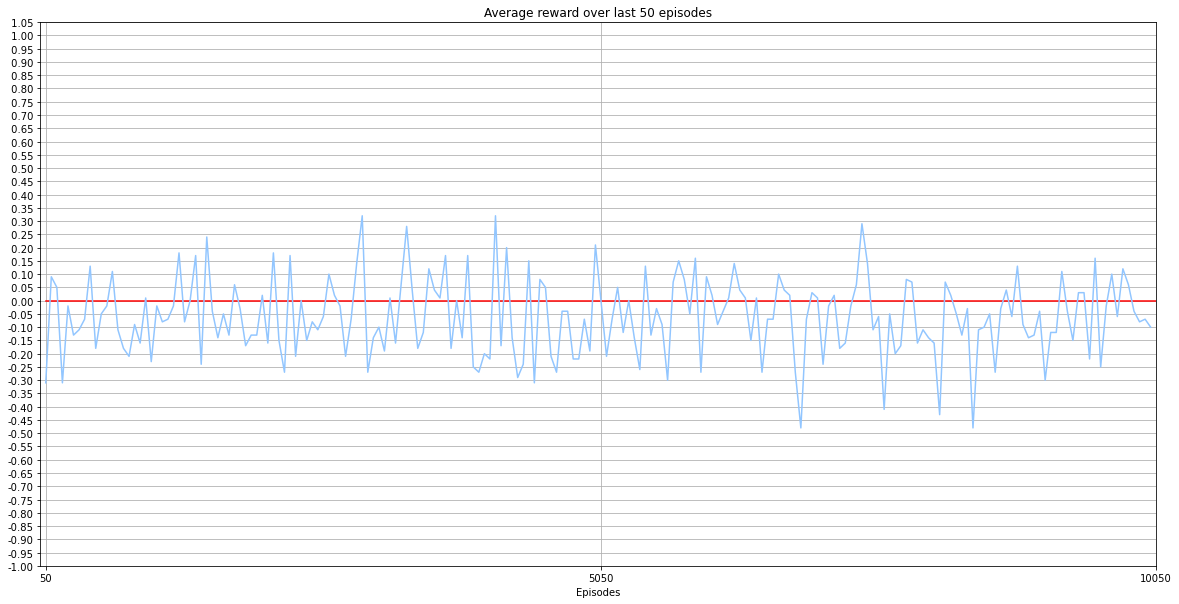

In [35]:
plot_reward_time_series(range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY),results);

#### **Learning proof**:
The agent is not learning, since prediction implies the evaluation of a given policy. However, I would like to take the opportunity to state the method I am hereafter using to prove the existence of learning:

**Augmented Dickey-Fuller test:**

I am assuming that the average reward time series is stationary when there is no learning. Therefore, Augmented Dickey-Fuller is fit for purpose. It tests the null hypothesis that the series is **not** stationary.

In [51]:
dickey_fuller(results)

'Null hypothesis can be rejected. The series is stationary.'

In [24]:
# Short statistical analysis:
runs = pd.Series(data=results, index=range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY))
runs.describe()

count    200.000000
mean      -0.100150
std        0.145783
min       -0.490000
25%       -0.200000
50%       -0.095000
75%        0.002500
max        0.350000
dtype: float64